In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
from lib.course import LECTURES, ASSIGNMENTS, IDX_TO_LECTURE
import math
from lib.etl import clean_viewing_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import datetime as dt

In [26]:
#sns.set_style('white')
sns.set()

In [4]:
vd = clean_viewing_data(pd.concat([l.viewing_data() for l in LECTURES]))
vd['date'] = [dt.datetime.date(d) for d in vd['time']] 

In [51]:
users = vd.user.unique()
diffs = []
for l in LECTURES:
    vdl = vd[vd.lecture == l.index]
    for u in users:
        first_view = vdl[vdl.user == u].date.min()
        if not isinstance(first_view, float):
            diffs.append({
                'user': u,
                'lecture': l.index,
                'days': (first_view - l.date.date()).days
            })
diffs = pd.DataFrame(diffs)            

In [52]:
diffs_filtered = diffs[diffs.days <= 15]

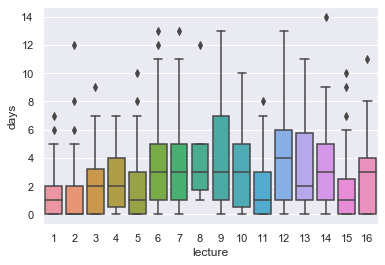

In [53]:
sns.boxplot(data=diffs_filtered, x='lecture', y='days')

Text(0, 0.5, 'Number of days before first watching lecture video')

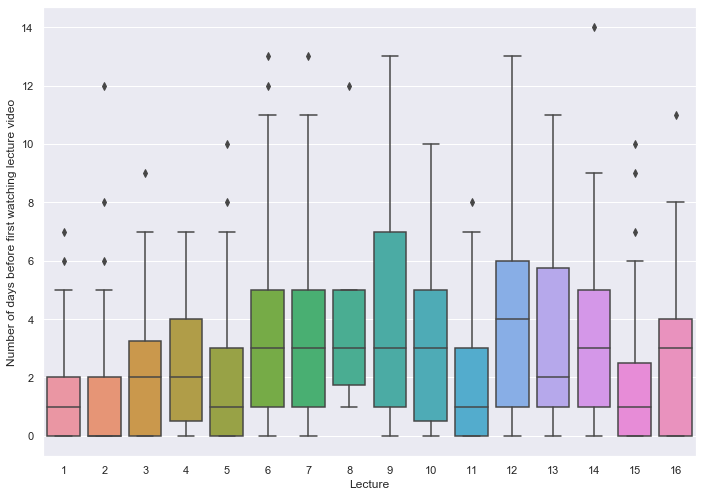

In [76]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=diffs_filtered, x='lecture', y='days')
ax.set_xlabel('Lecture')
ax.set_ylabel('Number of days before first watching lecture video')

Text(0, 0.5, 'Number of days before first watching lecture video')

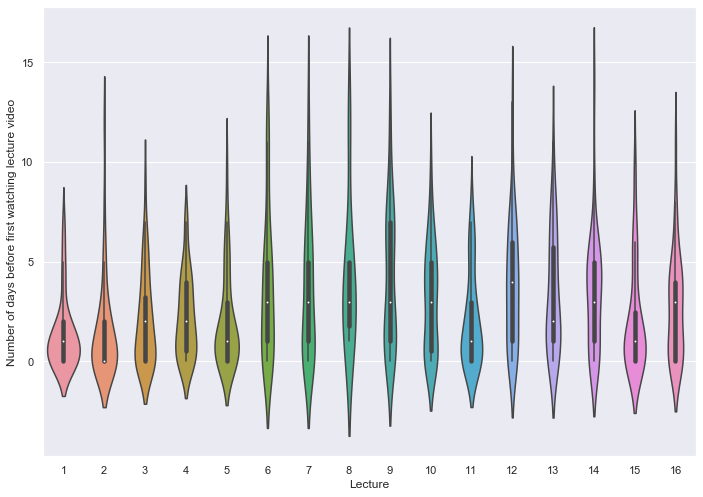

In [78]:
ax = sns.violinplot(data=diffs_filtered, x='lecture', y='days')
ax.set_xlabel('Lecture')
ax.set_ylabel('Number of days before first watching lecture video')

Text(0, 0.5, 'Number of days before first watching lecture video')

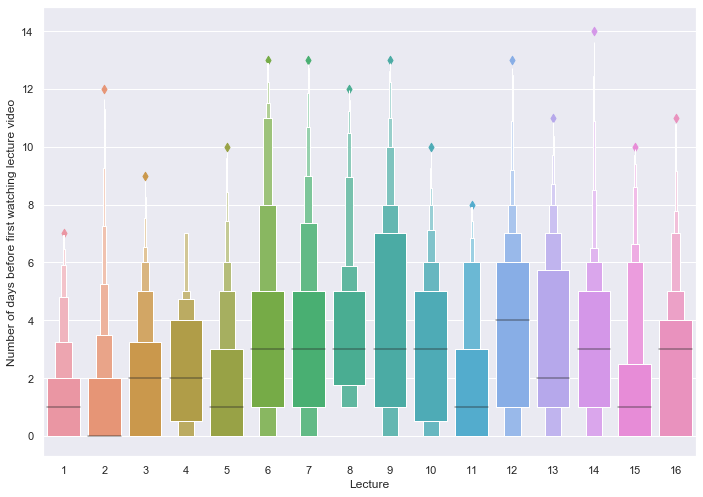

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxenplot(data=diffs_filtered, x='lecture', y='days')
ax.set_xlabel('Lecture')
ax.set_ylabel('Number of days before first watching lecture video')

In [79]:
cnt = diffs_filtered.groupby('user').count()
diffs_poweruser = diffs_filtered.set_index('user')[cnt.lecture >= 10].reset_index()

/Users/will/Code/lecture-intelligence/.env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


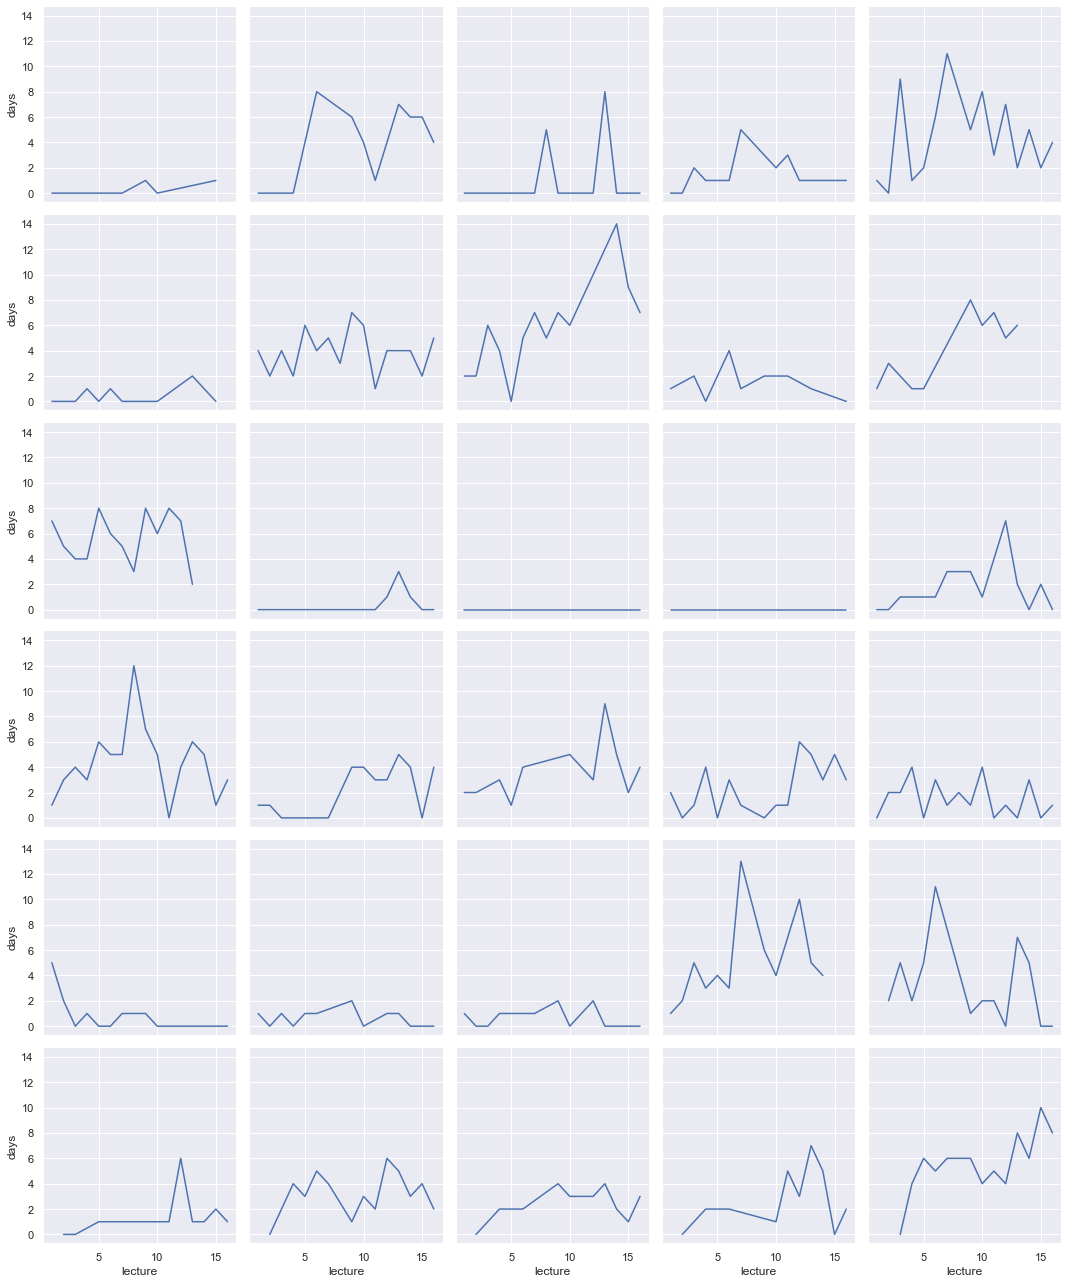

In [82]:
g = sns.FacetGrid(diffs_poweruser, col='user', col_wrap=5)
g.map(plt.plot, 'lecture', 'days')
g.set_titles('')
g.fig.tight_layout()

In [77]:
def day_to_string(day):
    days = ["M", "T", "W", "Th", "F", "Sat", "Sun"]
    return days[day]

In [31]:
ASSIGNMENTS[0]

Assignment(index=1, name='JSafe', duedate=datetime.datetime(2019, 10, 2, 0, 0), lectures=[2])

Text(0.5, 1.0, 'Total viewing over the quarter, separated by assignment')

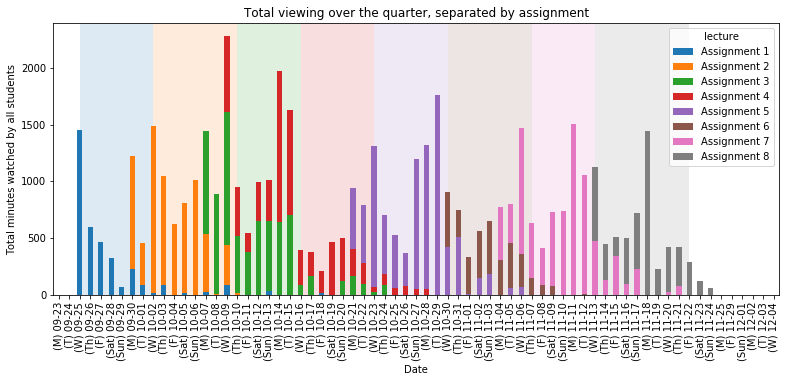

In [83]:
df = vd.groupby(['lecture', 'date']).sum()
df = df.reset_index().pivot(index='date', columns='lecture', values='minutes')
df = df.fillna(0)

palette = sns.color_palette('tab10')

# Draw background color on the midterm season
# plt.axvspan(3, 9, facecolor='blue', alpha=0.15)
# plt.axvspan(9, 18, facecolor='orange', alpha=0.15)
# plt.axvspan(17, 24, facecolor='green', alpha=0.15)
# plt.axvspan(23, 32, facecolor='red', alpha=0.15)
# plt.axvspan(31, 38, facecolor='purple', alpha=0.15)
# plt.axvspan(37, 45, facecolor='brown', alpha=0.15)

ax = plt.gca()



assign_keys = []
prev_x = 0
for i, a in enumerate(ASSIGNMENTS):
    k = f'Assignment {a.index}'
    df[k] = df.loc[:, a.lectures].sum(axis=1)
    assign_keys.append(k)
    
    if i == 0:
        prev = df[df['Assignment 1'] > 0].index.min()
        prev_x = (prev - df.index.min()).days
    else:
        prev = ASSIGNMENTS[i - 1].duedate.date()
    next_x = prev_x + (a.duedate.date() - prev).days
    ax.axvspan(prev_x, next_x, facecolor=palette[i], alpha=0.15)
    prev_x = next_x
    
    
df.loc[:, assign_keys].plot.bar(stacked=True, figsize=(13,5), ax=ax, color=palette)

# Popultes information in the ticks such that they aren't empty strings
#ax.draw()
# Get labels and format them
labels = ['({}) {}'.format(day_to_string(dt.datetime.strptime(item.get_text(),'%Y-%m-%d').weekday()), item.get_text()[5:])
          for item in ax.get_xticklabels()]
# Print labels
ax.set_xticklabels(labels)

# Add title, x-label, y-label
ax.set_xlabel('Date')
ax.set_ylabel('Total minutes watched by all students')
ax.set_title('Total viewing over the quarter, separated by assignment')

In [67]:
IDX_TO_LECTURE[2]

Lecture(index=2, name='Syntax and semantics', date=datetime.datetime(2019, 9, 25, 0, 0))

In [6]:
vd['date'] = vd['time'].dt.date
mean_late = []
for u in vd.user.unique():
    all_days_after = defaultdict(list)
    vdu = vd[vd.user == u]
    for lec in LECTURES:
        all_views = vdu[vdu.lecture == lec.index].groupby(
            'date').sum().reset_index()
        first_view = all_views[all_views.minutes > 10].date.min()
        if not pd.isna(first_view):
            days_after = (first_view - lec.date.date()).days
            all_days_after[lec.date.weekday()].append(days_after)

    for weekday, days_after in all_days_after.items():
        mean_late.append({
            'user': u,
            'late': pd.Series(days_after).median(),
            'cnt': len(days_after),
            'weekday': weekday
        })

        

# bins = np.arange(0, np.ceil(max(df.late) + .5) + 1)
# ax = plt.gca()
# df.hist('late', ax=ax, bins=bins - 0.5)
# ax.set_xlabel('Median number of days lecture is viewed after release')
# ax.set_ylabel('Number of students\n(who watched at least 5 lectures)')
# ax.set_title(
#     'How long do students wait on average before watching lecture?')

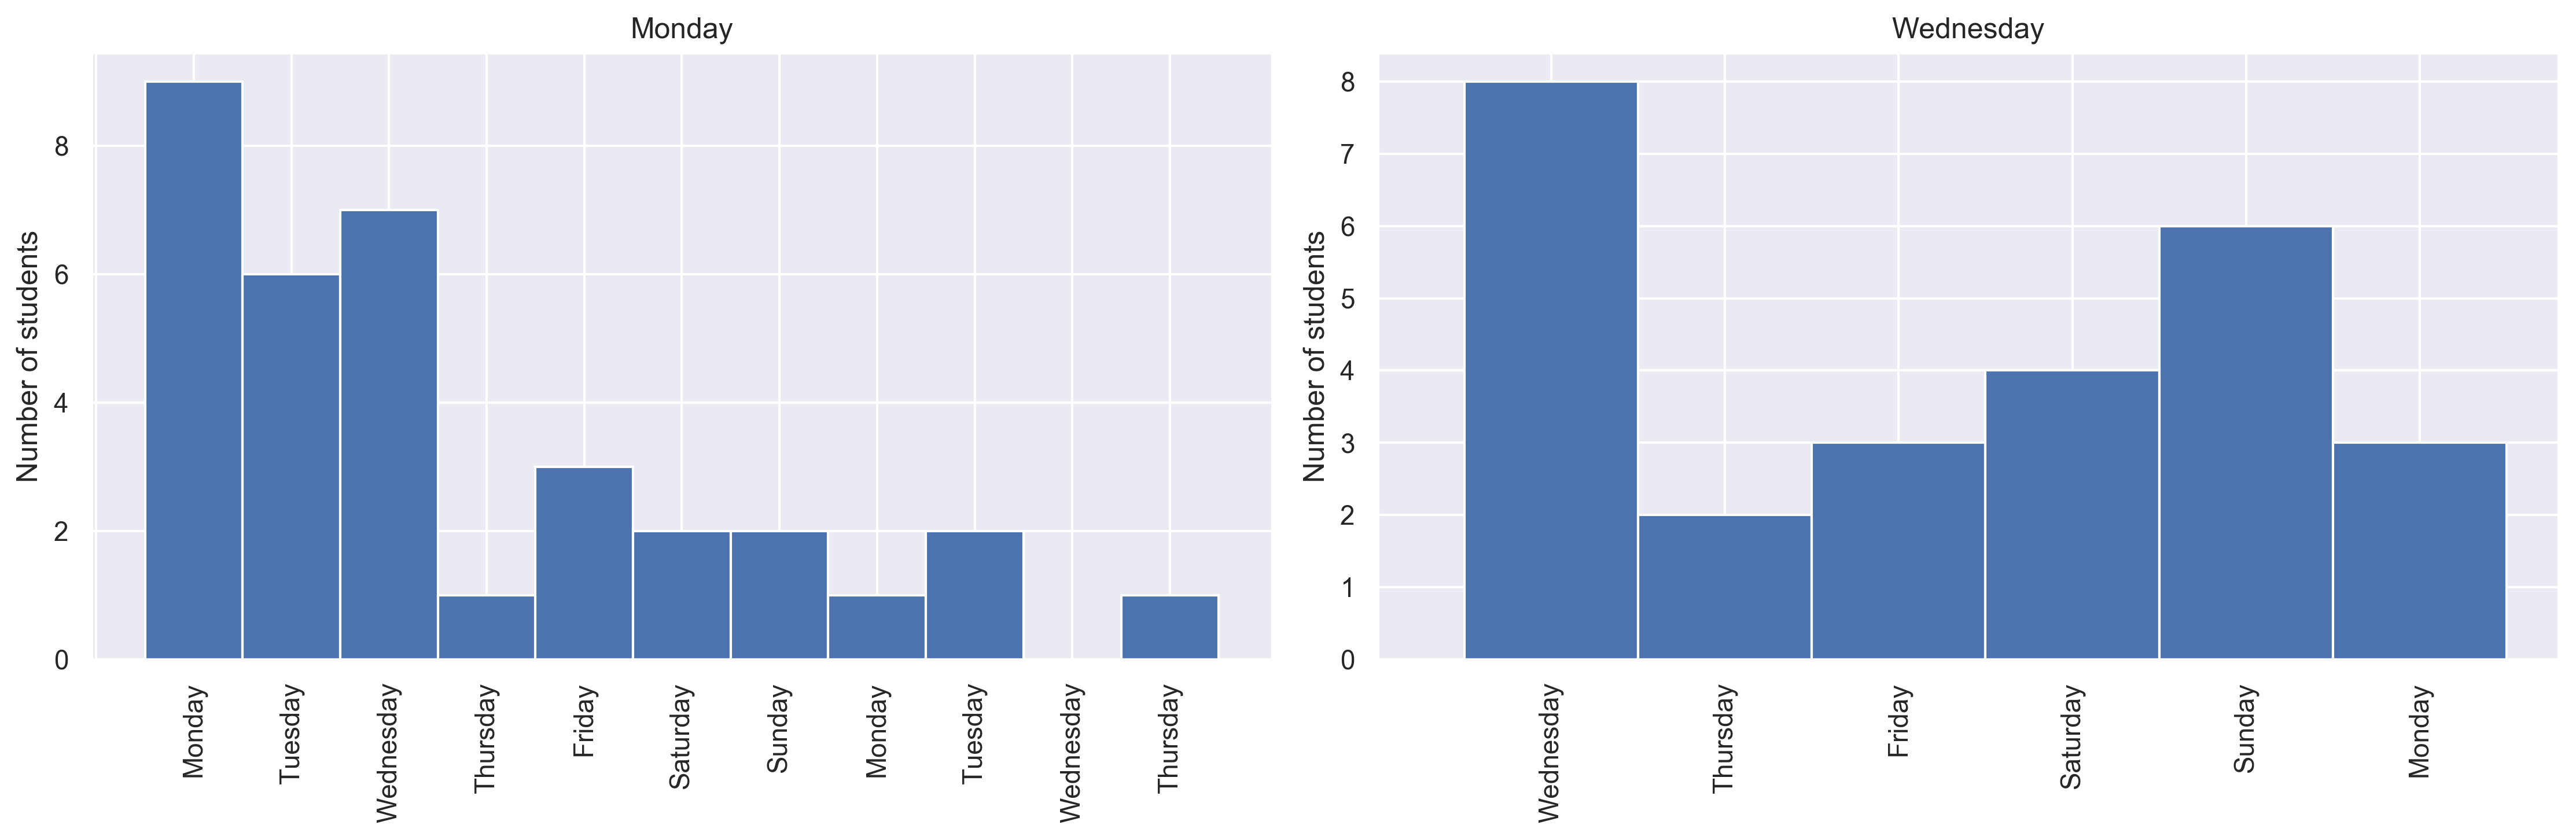

In [7]:
df = pd.DataFrame(mean_late)
df = df[df.cnt >= 5]

dotw_str = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

weekdays = df.weekday.unique()
_, axes = plt.subplots(1, len(weekdays),figsize=(15, 5), dpi=300)
#plt.suptitle('Median day of the week when a lecture video is watched')
for wd, ax in zip(weekdays, axes):
    dfwd = df[df.weekday == wd]
    bins = np.arange(0, max(dfwd.late)+1)
    dfwd.hist("late", ax=ax, bins=bins)
    ax.set_title(dotw_str[wd])
    ax.set_xticks(bins-0.5)
    ax.set_xticklabels([""] + [dotw_str[wd2%7] for wd2 in range(wd, wd+len(bins))], rotation=90, ha='center')
    ax.set_ylabel('Number of students')
    
plt.tight_layout()    
plt.savefig('lecture_lateness.pdf')    

In [8]:
df = vd.groupby(['user', 'date', 'lecture']).sum()
df = df[df.minutes > 30].reset_index().groupby(['user', 'date']).count().reset_index()
len(df[df.minutes == 3])

6

In [51]:
users = vd.user.unique()
cnts = defaultdict(lambda: defaultdict(int))
for a in ASSIGNMENTS:
    #lecs = [IDX_TOa_LECTURE[l] for l in a.lectures]
    for u in users:
        for l in a.lectures:
            vdu = vd[(vd.user == u) & (vd.lecture == l)]
            vdu = vdu.groupby('date').sum().reset_index()
            if vdu.minutes.sum() >= 45:
                for _, row in vdu.iterrows():
                    delta = a.duedate.date() - row.date
                    if delta.days <= 1:
                        cnts[u][a.index] += row.minutes

In [ ]:
user_names = defaultdict(str)
suids = {}
for _, row in pd.read_csv('../data/users.csv').iterrows():
    user_names[row['User ID']] = row['Name']
    suids[row['Email'].split('@')[0]] = row['User ID']

In [ ]:
def process_student(row):
    suid = row['Email'].split('@')[0]
    if suid not in suids:
        return None
        
    user_id = suids[suid]
    name = user_names[user_id]
    
    all_grades = {}
    for assgn in ASSIGNMENTS:
        key = f'Assignment {assgn.index}: {assgn.name}'
        if hasattr(row, key):
            keys = [key]
        else:
            keys = [key + ' - Written', key + ' - Programming']
            

        total_grade = 0
        total_max = 0
        for key in keys:
            grade = row[key]
            if math.isnan(grade):
                return None
            
            maxp = row[key + ' - Max Points']
            total_grade += grade
            total_max += maxp
        
        all_grades[assgn.index] = total_grade / total_max
        
    return {'user': user_id, 'grades': all_grades}
        
grades = pd.read_csv('../data/grades.csv')
outp_grades = []
for _, row in grades.iterrows():
    newrow = process_student(row)
    if newrow is not None:
        outp_grades.append(newrow)

In [53]:
outp = []
for a in ASSIGNMENTS:
    for row in outp_grades:
        grade = row['grades'][a.index]
        latemin = cnts[row['user']][a.index]
        outp.append({'grade': grade, 'latemin': latemin, 'assgn': a.index})

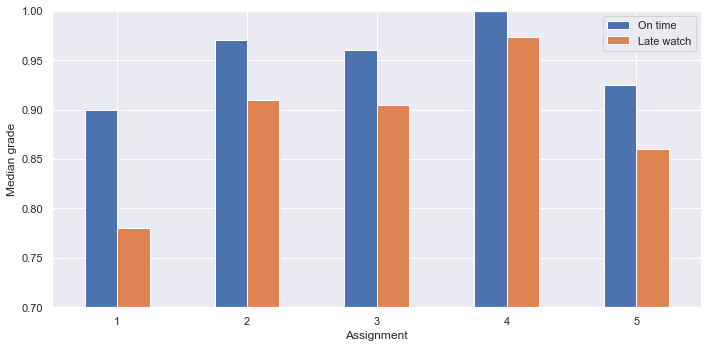

In [69]:
df = pd.DataFrame(outp)

grade_df = pd.concat(
    [df[df.latemin == 0].groupby('assgn').median().grade.rename('On time'),
     df[df.latemin > 0].groupby('assgn').median().grade.rename('Late watch')],
    axis=1
)
ax = grade_df.drop(grade_df.tail(3).index).plot.bar(figsize=(10, 5), rot=0)
ax.set_ylabel('Median grade')
ax.set_xlabel('Assignment')
ax.set_ylim(0.7, 1.0)
#ax.set_title('Median grade per assignment for students who watched lectures on time vs. late')

#df[df.latemin == 0].boxplot('grade', by='assgn')

plt.tight_layout()
plt.savefig('grade_diff.pdf')

In [57]:
df[df.latemin == 0].groupby('assgn').count().grade

assgn
1    84
2    87
3    76
4    80
5    63
6    83
7    67
8    83
Name: grade, dtype: int64

In [58]:
df[df.latemin > 0].groupby('assgn').count().grade

assgn
1     6
2     3
3    14
4    10
5    27
6     7
7    23
8     7
Name: grade, dtype: int64

In [59]:
df = df[df.assgn <= 5]
dist1 = df[df.latemin > 0 ].grade
dist2 = df[df.latemin == 0].grade

In [67]:
(df[df.latemin == 0].groupby('assgn').median() - df[df.latemin > 0].groupby('assgn').median()).grade.mean()

0.06525709999999998

In [61]:
import scipy.stats as stats

stats.kruskal(dist1, dist2)

KruskalResult(statistic=14.258656136325907, pvalue=0.00015932633996076088)

In [68]:
print(df[df.latemin == 0].groupby('assgn').count())
print(df[df.latemin > 0].groupby('assgn').count())

       grade  latemin
assgn                
1         84       84
2         87       87
3         76       76
4         80       80
5         63       63
       grade  latemin
assgn                
1          6        6
2          3        3
3         14       14
4         10       10
5         27       27


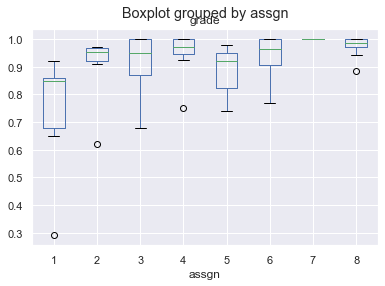

In [15]:
df[df.latemin > 0].boxplot('grade', by='assgn')

TypeError: lecture_heatmap() missing 1 required positional argument: 'lec'

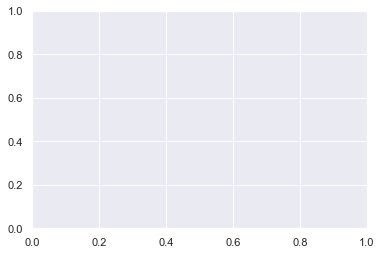

In [16]:
from lib.vis import lecture_heatmap

lecture_heatmap(vd, plt.gca(), )